In [2]:
import tensorflow as tf
import tensorflow.keras.models as models
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
(x_train,y_train),(x_test,y_test) = load_data(path="mnist.npz")

11490434/11490434 [==============================] - 0s 0us/step


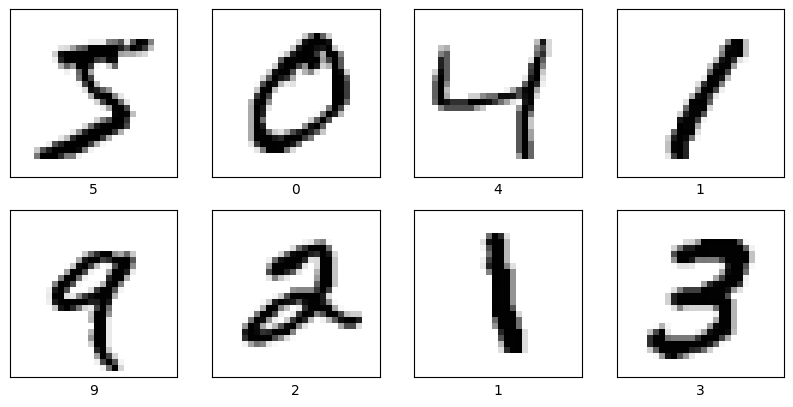

In [4]:
plt.figure(figsize=(10,10))
for i in range(0,8):
    plt.subplot(4,4,i+1)
    plt.imshow(x_train[i],cmap='binary')
    plt.xlabel(str(y_train[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [5]:
x_train = np.reshape(x_train,(x_train.shape[0],28*28))
x_test = np.reshape(x_test,(x_test.shape[0],28*28))

x_train =x_train/ 255
x_test =x_test/ 255

In [6]:
model = models.Sequential()
model.add(Dense(32,activation='relu',input_shape=(784,)))
model.add(Dense(32,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(10,activation='softmax'))

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics='accuracy')

In [7]:
_ = model.fit(x_train, y_train, 
              validation_data=(x_test,y_test),
              epochs = 20, 
              batch_size = 2048,
              verbose = 2,
             )

Epoch 1/20
30/30 - 2s - loss: 1.8311 - accuracy: 0.3956 - val_loss: 1.2488 - val_accuracy: 0.6122 - 2s/epoch - 65ms/step
Epoch 2/20
30/30 - 1s - loss: 0.8408 - accuracy: 0.7762 - val_loss: 0.5103 - val_accuracy: 0.8662 - 513ms/epoch - 17ms/step
Epoch 3/20
30/30 - 0s - loss: 0.4310 - accuracy: 0.8806 - val_loss: 0.3564 - val_accuracy: 0.9023 - 485ms/epoch - 16ms/step
Epoch 4/20
30/30 - 0s - loss: 0.3359 - accuracy: 0.9058 - val_loss: 0.3043 - val_accuracy: 0.9165 - 487ms/epoch - 16ms/step
Epoch 5/20
30/30 - 0s - loss: 0.2912 - accuracy: 0.9181 - val_loss: 0.2712 - val_accuracy: 0.9236 - 464ms/epoch - 15ms/step
Epoch 6/20
30/30 - 0s - loss: 0.2613 - accuracy: 0.9260 - val_loss: 0.2452 - val_accuracy: 0.9312 - 488ms/epoch - 16ms/step
Epoch 7/20
30/30 - 1s - loss: 0.2408 - accuracy: 0.9320 - val_loss: 0.2335 - val_accuracy: 0.9323 - 517ms/epoch - 17ms/step
Epoch 8/20
30/30 - 1s - loss: 0.2203 - accuracy: 0.9377 - val_loss: 0.2149 - val_accuracy: 0.9392 - 805ms/epoch - 27ms/step
Epoch 9/20


In [8]:
model.save('model.h5')

In [9]:
%%writefile ml_server.py

import json
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.datasets.mnist import load_data
import numpy as np
from flask import Flask, request

app = Flask(__name__)
model = tf.keras.models.load_model('model.h5')
feature_model = Model(model.inputs,
                     [layer.output for layer in model.layers])
_,(x_test,_) = load_data()
x_test = x_test/255.

def get_prediction():
    index = np.random.choice(x_test.shape[0])
    image = x_test[index,:,:]
    image_arr = np.reshape(image,(1,784))
    return feature_model.predict(image_arr),image
    

@app.route('/',methods=['GET','POST'])
def index():
    if request.method=='POST':
        preds,image = get_prediction()
        final_preds = [p.tolist() for p in preds]
        return json.dumps({
            'prediction':final_preds,
            'image': image.tolist()
        })
    return 'welcome to the model server'


if __name__ == '__main__':
    app.run()

Writing ml_server.py


In [17]:
!pip install -q streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 13.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 91.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.5 MB/s eta 0:00:00


In [10]:
%%writefile app.py
import numpy as np
import streamlit as st
import requests
import json
import matplotlib.pyplot as plt


URI = "http://127.0.0.1:5000/"

st.title("Neural Network Visualizer")
st.sidebar.markdown("Input Image")

if st.button('Get random prediction'):
    response = requests.post(URI,data={})
    response = json.loads(response.text)
    preds = response.get('prediction')
    image = response.get('image')
    image = np.reshape(image,(28,28))
    
    st.sidebar.image(image,width=150)
    
    for layer,p in enumerate(preds):
        numbers = np.squeeze(np.array(p))
        plt.figure(figsize=(32,4))
        if layer == 3:
            row = 1
            col = 10 
        else:
            row = 2 
            col = 16
        for i,number in enumerate(numbers):
            plt.subplot(row,col,i+1)
            plt.imshow(number*np.ones((8,8,3)).astype('float32'))
            plt.xticks([])
            plt.yticks([])
            
            if layer ==3:
                plt.xlabel(str(i),fontsize=40)
        plt.subplots_adjust(wspace=0.05, hspace=0.05, )
        plt.tight_layout()
        st.text('Layer{}'.format(layer))
        st.pyplot()

Writing app.py
